# Аналіз емоцій

В роботі розглянуте визначення емоційного забарвлення текстових повідомлень із
[вибірки](https://www.kaggle.com/datasets/nursyahrina/chat-sentiment-dataset), що згенерована ChatGPT. Сумарно 584
документи мають одну з трьох позначок — `positive`, `neutral` та `negative`. Потрібно створити класифікатор, що для
заданого тексту визначатиме його емоційне забарвлення.

In [1]:
from matplotlib.pyplot import subplots
from numpy import arange
from pandas import read_csv
from seaborn import set_style, barplot, heatmap
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
set_style('darkgrid')

In [3]:
chat = read_csv('data/chat_dataset.csv')

In [4]:
chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    584 non-null    object
 1   sentiment  584 non-null    object
dtypes: object(2)
memory usage: 9.3+ KB


In [5]:
chat.head(10)

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative
5,This is a great product,positive
6,I wouldn't recommend this,negative
7,The price is a bit high,neutral
8,The weather is perfect today,positive
9,The traffic is horrible,negative


Хоча датасет є синтетичним і його класи не є ідеально збалансованими, в подальших обчисленнях вважатимемо їх такими,
що не потребують зважування за розміром.

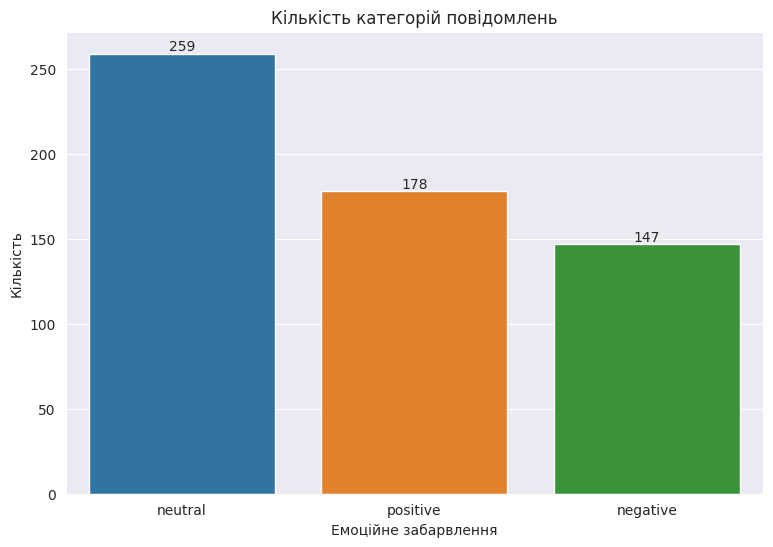

In [6]:
sentiment_counts = chat['sentiment'].value_counts()
axes = subplots(figsize=(9, 6))[1]
barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes)
for container in axes.containers:
    axes.bar_label(container)
axes.set_title('Кількість категорій повідомлень')
axes.set_xlabel('Емоційне забарвлення')
axes.set_ylabel('Кількість');

In [7]:
train_messages, test_messages, train_sentiments, test_sentiments = train_test_split(
    chat['message'],
    chat['sentiment'],
    test_size=0.25,
    stratify=chat['sentiment']
)

## Логістична регресія

Оскільки ми працюємо з текстом, в пайплайн обробки слід додати векторизатор. Для цього був обраний
[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html),
що добре себе зарекомендував у подібних задачах. Оскільки його виведення є розрідженою матрицею, для зменшення
розмірності замість PCA обрано
[TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). А найпершим
алгоритмом класифікації обрана стара добра
[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [8]:
logistic_regression_pipeline = make_pipeline(
    CountVectorizer(),
    TruncatedSVD(),
    LogisticRegression(max_iter=300)
)

В просторі гіперпараметрів також задаємо опції векторизатора — можливість інженерити не тільки поодинокі слова, а й
біграми.

In [9]:
logistic_regression_distributions = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'truncatedsvd__n_components': [5, 50, 500],
    'logisticregression__C': 10.0 ** arange(-2, 3, 1)
}

Тут задаємо [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
усіх опцій зі
[StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) 
крос-валідацією на 5 фрагментів.

In [10]:
logistic_regression_cv = GridSearchCV(
    logistic_regression_pipeline,
    logistic_regression_distributions,
    n_jobs=4,
    cv=5
)

In [11]:
%%time
logistic_regression_cv.fit(train_messages, train_sentiments);

CPU times: user 1.67 s, sys: 1.85 s, total: 3.52 s
Wall time: 5.92 s


In [12]:
logistic_regression_cv.best_score_

0.7900470219435738

In [13]:
logistic_regression_cv.best_params_

{'countvectorizer__ngram_range': (1, 2),
 'logisticregression__C': 100.0,
 'truncatedsvd__n_components': 500}

In [14]:
predicted_sentiments = logistic_regression_cv.best_estimator_.predict(test_messages)

In [15]:
accuracy_score(test_sentiments, predicted_sentiments)

0.8493150684931506

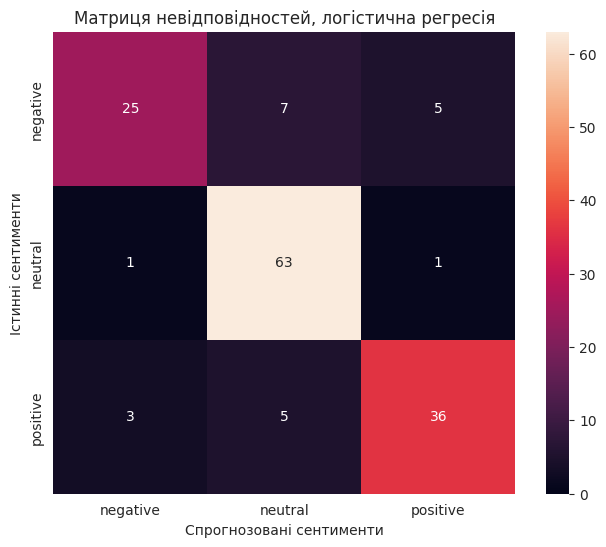

In [16]:
axes = subplots(figsize=(8, 6))[1]
matrix = confusion_matrix(test_sentiments, predicted_sentiments)
labels = logistic_regression_cv.best_estimator_['logisticregression'].classes_
chart = heatmap(
    matrix,
    annot=True,
    ax=axes,
    vmin=0,
    fmt='d',
    square=True
)
chart.set_xticklabels(labels)
chart.set_yticklabels(labels)
axes.set_title('Матриця невідповідностей, логістична регресія')
axes.set_xlabel('Спрогнозовані сентименти')
axes.set_ylabel('Істинні сентименти');

Як бачимо, найбільше помилок серед негативних відгуків, що вважаються нейтральними.

In [46]:
test_messages[(test_sentiments == 'negative') & (predicted_sentiments == 'neutral')]

132                                 I did not enjoy this
145                            This is a useless product
34                            This product is overpriced
160                             The hotel was overpriced
157                    The view from here is unappealing
133                                 The car is expensive
499    I'm so sick and tired of feeling sick and tire...
135              The service at this restaurant was poor
573    I have to work on Saturday this week and I was...
149                   The service at this hotel was poor
Name: message, dtype: object

## Випадковий ліс

А тепер перевіримо ансамблі у вигляді
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
Тут той самий векторизатор, але без масштабування ознак чи зменшення розмірності.

In [18]:
random_forest_pipeline = make_pipeline(CountVectorizer(), RandomForestClassifier())

In [19]:
random_forest_distributions = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'randomforestclassifier__n_estimators': [1, 5, 20, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 2, 5, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5],
    'randomforestclassifier__max_leaf_nodes': [None, 2, 5, 10]
}

А тут насправді великий простір гіперпараметрів, для прискорення обчислення використаємо вибіркову
[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [20]:
random_forest_cv = RandomizedSearchCV(
    random_forest_pipeline,
    random_forest_distributions,
    n_iter=100,
    n_jobs=8,
    cv=5
)

In [21]:
%%time
random_forest_cv.fit(train_messages, train_sentiments);

CPU times: user 577 ms, sys: 72.7 ms, total: 650 ms
Wall time: 8.19 s


In [22]:
random_forest_cv.best_score_

0.7467084639498431

До речі, забавно, що випадковий ліс обирає якомога більше "слабких учнів" замість обмежень по росту й поділу вузлів.

In [23]:
random_forest_cv.best_params_

{'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_depth': None,
 'countvectorizer__ngram_range': (1, 1)}

In [24]:
predicted_sentiments = random_forest_cv.best_estimator_.predict(test_messages)

In [25]:
accuracy_score(test_sentiments, predicted_sentiments)

0.8013698630136986

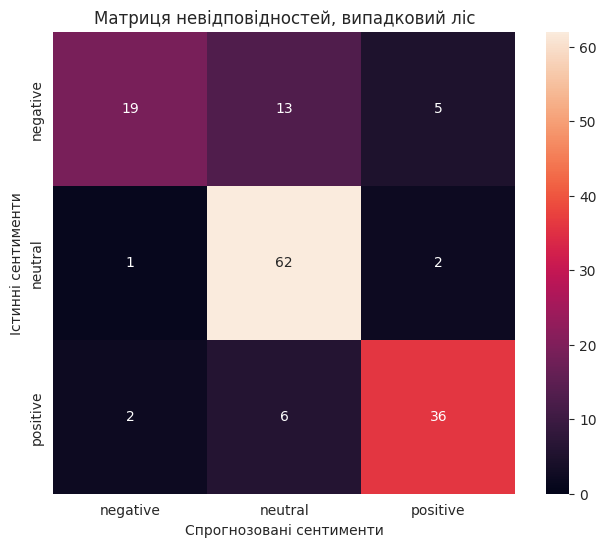

In [26]:
axes = subplots(figsize=(8, 6))[1]
matrix = confusion_matrix(test_sentiments, predicted_sentiments)
labels = random_forest_cv.best_estimator_['randomforestclassifier'].classes_
chart = heatmap(
    matrix,
    annot=True,
    ax=axes,
    vmin=0,
    fmt='d',
    square=True
)
chart.set_xticklabels(labels)
chart.set_yticklabels(labels)
axes.set_title('Матриця невідповідностей, випадковий ліс')
axes.set_xlabel('Спрогнозовані сентименти')
axes.set_ylabel('Істинні сентименти');

Забавно, ця модель також робить немало помилок серед негативних відгуків :)

In [27]:
test_messages[(test_sentiments == 'negative') & (predicted_sentiments == 'neutral')]

132                         I did not enjoy this
150                  This phone is disappointing
145                    This is a useless product
59     I regret wasting my money on this product
155                   The food was below average
34                    This product is overpriced
160                     The hotel was overpriced
37             The car broke down on the highway
157            The view from here is unappealing
133                         The car is expensive
495         I can't believe I failed that exam 😭
67                    I didn't enjoy this at all
149           The service at this hotel was poor
Name: message, dtype: object

## SVM + RBF

Настала черга [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) з RBF-ядром і зменшенням
розмірності.

In [28]:
rbf_svm_pipeline = make_pipeline(CountVectorizer(), TruncatedSVD(), SVC())

In [29]:
rbf_svm_distributions = {
    'truncatedsvd__n_components': [5, 50, 500],
    'svc__C': 10.0 ** arange(-2, 3, 1),
    'svc__gamma': ['scale', 'auto']
}

In [30]:
rbf_svm_cv = GridSearchCV(rbf_svm_pipeline, rbf_svm_distributions, n_jobs=8, cv=5)

In [31]:
%%time
rbf_svm_cv.fit(train_messages, train_sentiments);

CPU times: user 803 ms, sys: 1.02 s, total: 1.83 s
Wall time: 2.23 s


In [32]:
rbf_svm_cv.best_score_

0.7924242424242425

In [33]:
rbf_svm_cv.best_params_

{'svc__C': 100.0, 'svc__gamma': 'auto', 'truncatedsvd__n_components': 500}

In [34]:
predicted_sentiments = rbf_svm_cv.best_estimator_.predict(test_messages)

In [35]:
accuracy_score(test_sentiments, predicted_sentiments)

0.8424657534246576

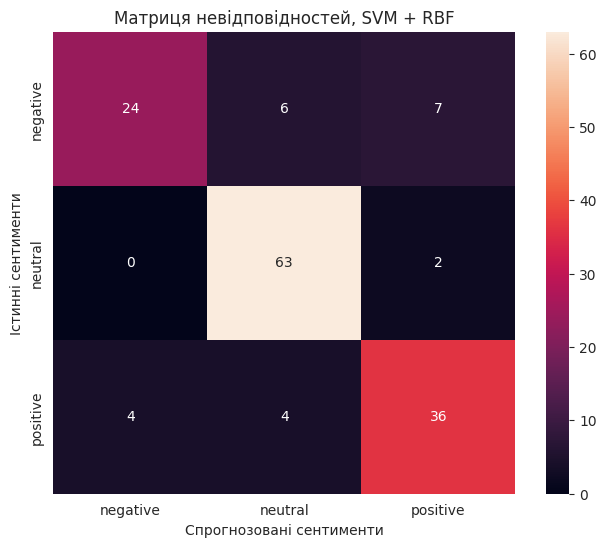

In [36]:
axes = subplots(figsize=(8, 6))[1]
matrix = confusion_matrix(test_sentiments, predicted_sentiments)
labels = rbf_svm_cv.best_estimator_['svc'].classes_
chart = heatmap(
    matrix,
    annot=True,
    ax=axes,
    vmin=0,
    fmt='d',
    square=True
)
chart.set_xticklabels(labels)
chart.set_yticklabels(labels)
axes.set_title('Матриця невідповідностей, SVM + RBF')
axes.set_xlabel('Спрогнозовані сентименти')
axes.set_ylabel('Істинні сентименти');

## Лінійний SVM

У лінійному SVC замість зменшення розмірності для покращення збіжності поставимо масштабування ознак, яке зберігає
розрідженість введення.

In [37]:
linear_svm_pipeline = make_pipeline(CountVectorizer(), StandardScaler(with_mean=False), SVC(kernel='linear'))

In [38]:
linear_svm_distributions = {'svc__C': 10.0 ** arange(-2, 3, 1), 'svc__gamma': ['scale', 'auto']}

In [39]:
linear_svm_cv = GridSearchCV(linear_svm_pipeline, linear_svm_distributions, n_jobs=8, cv=5)

In [40]:
%%time
linear_svm_cv.fit(train_messages, train_sentiments);

CPU times: user 84.1 ms, sys: 3.54 ms, total: 87.7 ms
Wall time: 254 ms


In [41]:
linear_svm_cv.best_score_

0.7785527690700104

In [42]:
linear_svm_cv.best_params_

{'svc__C': 0.01, 'svc__gamma': 'scale'}

In [43]:
predicted_sentiments = linear_svm_cv.best_estimator_.predict(test_messages)

In [44]:
accuracy_score(test_sentiments, predicted_sentiments)

0.8287671232876712

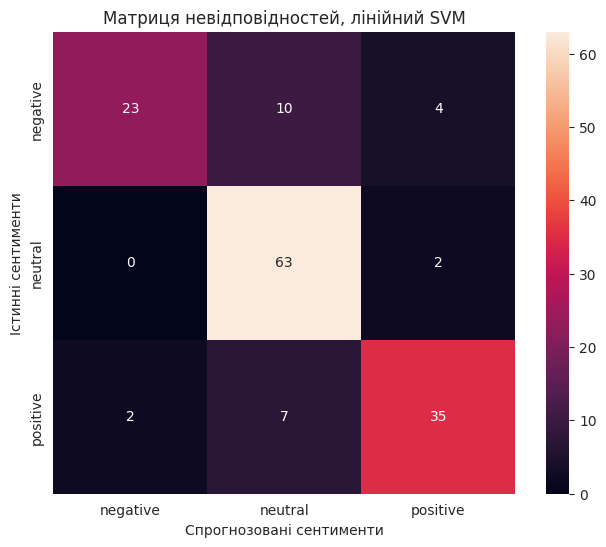

In [45]:
axes = subplots(figsize=(8, 6))[1]
matrix = confusion_matrix(test_sentiments, predicted_sentiments)
labels = linear_svm_cv.best_estimator_['svc'].classes_
chart = heatmap(
    matrix,
    annot=True,
    ax=axes,
    vmin=0,
    fmt='d',
    square=True
)
chart.set_xticklabels(labels)
chart.set_yticklabels(labels)
axes.set_title('Матриця невідповідностей, лінійний SVM')
axes.set_xlabel('Спрогнозовані сентименти')
axes.set_ylabel('Істинні сентименти');

## Висновки

Поропоную поглянути на кінцеву точність моделей на валідаційній та тестовій вибірках:

Точність|Логістична регресія|Випадковий ліс|SVM + RBF|лінійний SVM|
|---|---:|---:|---:|---:|
|Валідаційна|0.790|0.747|0.792|0.779|
|Тестова|0.849|0.801|0.842|0.829|

Як бачимо, найкраще прогнозує логістична регресія, найгірше — випадковий ліс. Різниця результативності істотна,
відсотки точності. В усіх алгоритмів тестова метрика більша за валідаційну. Також характерно те, що всі послуговувалися
виключно уніграмами. Одна з найбільш чисельних помилок — коли негативні відгуки вважаються нейтральними. Можливо, надто
рідкісні ознаки, або ж недостатньо токсичні :) В цілому, вибірка є занадто маленькою, аби результати на ній вважалися
достовірними. 